In [1]:
import cv2
import numpy as np
from scipy.ndimage import rotate
from os import listdir
from os.path import isfile, join
from pathlib import Path
import matplotlib.pyplot as plt
# import pandas as pd

In [5]:
image1 = cv2.imread('../data/templates/1.png')
template1 = image1[20:100, 15:95]
# cv2.imwrite("../data/templates/head1.png", template1)

image2 = cv2.imread('../data/templates/2.png')
template2 = image2[20:100, 15:95]
# cv2.imwrite("../data/templates/head2.png", template2)

image3 = cv2.imread('../data/templates/3.png')
template3 = cv2.resize(image3[30:130, 10:110], (80, 80))
# cv2.imwrite("../data/templates/head3.png", template3)

image4 = cv2.imread('../data/CC Lake slice/DSC00843.jpg')
template4 = cv2.resize(cv2.flip(image4, 0)[125:225, 180:280], (80, 80))
# cv2.imwrite("../data/templates/head4.png", template4)

image5 = cv2.imread('../data/CC Lake slice/DSC00849.jpg')
template5 = cv2.resize(cv2.flip(image5, 0)[100:200, 220:320], (80, 80))
# cv2.imwrite("../data/templates/head5.png", template5)
# plt.imshow(cv2.cvtColor(template4, cv2.COLOR_BGR2RGB))

In [6]:
def match(image, temp0, slow=0.8, shigh=1.21, method = cv2.TM_CCORR_NORMED): 
    img = np.copy(image)
    best_res = None
    best_score = 0
    for s in np.arange(slow, shigh, 0.05):
        temp = cv2.resize(temp0, None, fx = s, fy = s)
        if image.shape[0] < temp.shape[0]: 
            break
        res = cv2.matchTemplate(image, temp, method)
        minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(res, None)
        if res.max() >= best_score:
            best_score = res.max()
            output = (best_score, maxLoc, temp, res, s)

    return output

In [7]:
def multitemp_match(image, templst): 
    tempscores = []
    temps = []
    Locs = []
    scales = []
    # output = (best_score, maxLoc, temp, res, s)
    for temp0 in templst: 
        output = match(image, temp0, method = cv2.TM_CCORR_NORMED)
        tempscores.append(output[0])
        temps.append(output[2])
        Locs.append(output[1])
        scales.append(output[4])
    
    idx = np.array(tempscores).argmax()
    score = tempscores[idx]
    Loc = Locs[idx]
    temp = temps[idx]
    scale = scales[idx]
    return score, Loc, temp, idx, scale

In [8]:
def get_templst(): 
    temp_path = '../data/templates/'
    temp_names = ['head1.png', 'head2.png', 'head3.png', 'head4.png', 'head5.png']
    templst = []
    for i in temp_names: 
        templst.append(cv2.imread(join(temp_path, i)))
#     print(templst)
    return templst

In [15]:
# all templates tested: 
templst = get_templst()

# image = cv2.imread('../data/CC Lake extracted/5/DSC00839.jpg')
# test multiple images
path = "../data/CC Lake extracted/5/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

# also flip image: 
for f in onlyfiles[10:20]:
    image = cv2.imread(join(path, f))
    img_in = cv2.GaussianBlur(np.copy(image), ksize = (3, 3), sigmaX = 1, borderType = cv2.BORDER_REPLICATE)
    
    best_score = 0
    best_img = None
    best_Loc, best_temp = None, None
    best_idx, best_scale = None, None
    left_img = cv2.flip(img_in, 0)
    up_img = cv2.flip(img_in, 1)
    for img in [img_in, left_img, left_img]: 
        score, Loc, temp, idx, scale = multitemp_match(img, templst)
        if score > best_score: 
            best_score = score
            best_img = img
            best_Loc = Loc
            best_temp = temp
            best_idx = idx
            best_scale = scale
    print(best_score, best_idx, best_scale)
    # image_out = cv2.rectangle(image, Loc, Loc, (0, 0, 255), 2)
    image_out = cv2.rectangle(best_img, best_Loc, (best_Loc[0]+best_temp.shape[1], best_Loc[1]+best_temp.shape[0]), (0, 0, 255), 2)

    fig, (ax2) = plt.subplots(1, 1)
#     ax0.imshow(temp, cmap = plt.cm.gray)
    # ax1.imshow(res, cmap = plt.cm.gray)
    print(image_out)
    ax2.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)) 

In [10]:
# mark eye landmarks on templates
templst = get_templst()

temp = templst[0]
lm1 = [35, 41]
lm2 = [35, 74]

temp = templst[1]
lm1 = [34, 40]
lm2 = [34, 75]

temp = templst[2]
lm1 = [34, 41]
lm2 = [34, 75]

temp = templst[3]
lm1 = [34, 41]
lm2 = [34, 75]

temp = templst[4]
lm1 = [34, 40]
lm2 = [34, 68]

# plt.figure()
# plt.imshow(temp)
# plt.plot(lm1[1], lm1[0],  c='red', marker='o')
# plt.plot(lm2[1], lm2[0],  c='red', marker='o')

In [12]:
def get_eyelm(idx): 
    if idx == 0: 
        return ([35, 41], [35, 74])
    elif idx == 1: 
        return ([34, 40], [34, 75])
    elif idx == 2 or idx == 3: 
        return ([34, 41], [34, 75])
    elif idx == 4: 
        return ([34, 40], [34, 68])
    else: 
        return None

In [13]:
templst = get_templst()
path = "../data/CC Lake extracted/5/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
# also flip image: 
for f in onlyfiles[10:22]:
    image = cv2.imread(join(path, f))
    img_in = cv2.GaussianBlur(np.copy(image), ksize = (3, 3), sigmaX = 1, borderType = cv2.BORDER_REPLICATE)
    
    best_score = 0
    best_img = None
    best_Loc, best_temp = None, None
    best_idx, best_scale = None, None
    left_img = cv2.flip(img_in, 0)
    up_img = cv2.flip(img_in, 1)
    for img in [img_in, left_img, left_img]: 
        score, Loc, temp, idx, scale = multitemp_match(img, templst)
        if score > best_score: 
            best_score = score
            best_img = img
            best_Loc = Loc
            best_temp = temp
            best_idx = idx
            best_scale = scale
    print(best_score, best_idx, best_scale)
    # get eye landmarks
    lm1, lm2 = get_eyelm(best_idx)
    print(lm1, lm2)
    # get scaled and shifted landmark, in x, y format
    eyelm1 = (best_Loc[0]+int(lm1[1]*best_scale), best_Loc[1]+int(lm1[0]*best_scale))
    eyelm2 = (best_Loc[0]+int(lm2[1]*best_scale), best_Loc[1]+int(lm2[0]*best_scale))
    image_out = cv2.rectangle(best_img, best_Loc, (best_Loc[0]+best_temp.shape[1], best_Loc[1]+best_temp.shape[0]), (0, 0, 255), 2)
    image_out = cv2.circle(image_out, eyelm1, radius=3, color=(0, 0, 255), thickness=-1)
    image_out = cv2.circle(image_out, eyelm2, radius=3, color=(0, 0, 255), thickness=-1)
    fig, (ax2) = plt.subplots(1, 1)
#     ax0.imshow(temp, cmap = plt.cm.gray)
    # ax1.imshow(res, cmap = plt.cm.gray)
    ax2.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB)) 

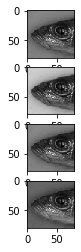

In [14]:
# identify eyes automatically
heads = get_templst()
head = heads[3]


gray = cv2.cvtColor(head, cv2.COLOR_BGR2GRAY)
blue = head[: ,:, 0]
green = head[: ,:, 1]
red = head[: ,:, 2]
hsv = cv2.cvtColor(head, cv2.COLOR_BGR2HSV)
h = hsv[:, :, 0]
s = hsv[:, :, 1]
v = hsv[:, :, 2]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1)
ax0.imshow(gray, cmap = plt.cm.gray)
ax1.imshow(blue, cmap = plt.cm.gray)
ax2.imshow(green, cmap = plt.cm.gray) 
ax3.imshow(red, cmap = plt.cm.gray) 



In [ ]:
# find circle by dilation and erosion? 
dilation = cv2.dilate(gray, cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (3, 3)))
# plt.imshow(dilation, cmap = plt.cm.gray)
erosion = cv2.erode(dilation, cv2.getStructuringElement(cv2.MORPH_RECT, ksize = (3, 3)))
diff = erosion - dilation
plt.imshow(diff, cmap=plt.cm.gray)

In [ ]:
# find eyes by NTSC
for head in heads: 
    RGBImage = cv2.cvtColor(np.copy(head), cv2.COLOR_BGR2RGB)
    YIQ = np.zeros_like(head)
    YIQ[:,:,0] = 0.299*RGBImage[:,:,0] + 0.587*RGBImage[:,:,1] + 0.114*RGBImage[:,:,2]
    YIQ[:,:,1] = 0.596*RGBImage[:,:,0] - 0.274*RGBImage[:,:,1] - 0.322*RGBImage[:,:,2]
    YIQ[:,:,2] = 0.211*RGBImage[:,:,0] - 0.523*RGBImage[:,:,1] + 0.312*RGBImage[:,:,2]
    Chrom = YIQ[:, :, 1]/(255*2) + YIQ[:, :, 2]/(255*2)
    print(Chrom.shape)
    
    
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1)
    ax0.imshow(YIQ)
    ax1.imshow(YIQ[:, :, 0], cmap=plt.cm.gray)
    ax2.imshow(YIQ[:, :, 1], cmap=plt.cm.gray)
    ax3.imshow(YIQ[:, :, 2], cmap=plt.cm.gray)
    ax4.imshow(Chrom, cmap=plt.cm.gray)

    
#     plt.imshow(Chrom, cmap=plt.cm.gray)

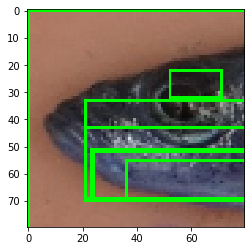

In [21]:
heads = get_templst()
for head in heads[3:4]: 
    RGBImage = cv2.cvtColor(np.copy(head), cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(np.copy(head), cv2.COLOR_BGR2HSV)
    YIQ = np.zeros_like(head)
    YIQ[:,:,0] = 0.299*RGBImage[:,:,0] + 0.587*RGBImage[:,:,1] + 0.114*RGBImage[:,:,2]
    YIQ[:,:,1] = 0.596*RGBImage[:,:,0] - 0.274*RGBImage[:,:,1] - 0.322*RGBImage[:,:,2]
    YIQ[:,:,2] = 0.211*RGBImage[:,:,0] - 0.523*RGBImage[:,:,1] + 0.312*RGBImage[:,:,2]
    Chrom = np.uint8(YIQ[:, :, 1]/2 + YIQ[:, :, 2]/2)
    mser = cv2.MSER_create()
#     mser.setDelta(1)
#     mser.setMinArea(100)
#     mser.setMaxArea(300)
    regions, boundingBoxes = mser.detectRegions(hsv)
#     regions, boundingBoxes = mser.detectRegions(cv2.cvtColor(np.copy(head), cv2.COLOR_BGR2GRAY))
#     regions, boundingBoxes = mser.detectRegions(hsv[:, :, 2])

    for box in boundingBoxes:
        x, y, w, h = box;
#         if w/h < 1.3 and w/h > 0.8: 
        cv2.rectangle(head, (x, y), (x+w, y+h), (0, 255, 0), 1)
    fig, (ax0) = plt.subplots(1, 1)
    ax0.imshow(head)

In [44]:
def filter(image):
#     image = cv2.imread(fname)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # key is to find a binary template before findContours!
    # one option is hsv sat (0, 70)
    val = hsv[:, :, 2]
#     sat = cv2.medianBlur(sat, ksize = 3)
    vmask = cv2.inRange(cv2.medianBlur(val, ksize = 3), 40, 255)/255
    rgbmask = cv2.inRange(image, (50, 50, 50), (255, 255, 255))/255
    print(image.shape, vmask.shape, rgbmask.shape)
    return vmask, rgbmask

(80, 80, 3) (80, 80) (80, 80)
[[[58.5 28.5 11.8]]]


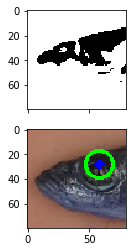

In [63]:
heads = get_templst()
head = heads[3]
vmask, rgbmask = filter(head)
# comb = (vmask + rgbmask)/2

comb = np.uint8(np.minimum(vmask, rgbmask)*255)
# print(comb)
# m, n = comb.shape[:2]
# # comb[:, n//5:] = 255
comb = cv2.medianBlur(comb, 5)
# plt.imshow(comb)
img = np.copy(head)
# #     comb = np.uint8((vmask + rgbmask)/2 * 255)
circles = cv2.HoughCircles(comb, cv2.HOUGH_GRADIENT, dp = 1, minDist = 10, param1=250, param2=10, minRadius=10, maxRadius=30)
# #     circles = np.uint16(np.around(circles))
print(circles)
if circles is not None:
    for i in circles[0,:]:
             # draw the outer circle
        cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
        cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
        #    print(circles)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.imshow(comb, cmap=plt.cm.gray)
    ax2.imshow(img)

# fig, (ax3, ax4, ax5) = plt.subplots(3, 1, sharex=True)
# #     ax1.imshow(hsv[:, :, 0], cmap=plt.cm.gray)
# #     ax2.imshow(hsv[:, :, 1], cmap=plt.cm.gray)
# ax3.imshow(comb, cmap=plt.cm.gray)
# ax4.imshow(vmask, cmap=plt.cm.gray)
# ax5.imshow(rgbmask, cmap=plt.cm.gray)